# Logistic Regression Analysis

*Written by Jin Cheong & Luke Chang*

In this lab we are going to learn about more advanced topics in regression analysis.
- How to use link functions to perform regressions on other types of data such as categorical variables
- How to perform cross-validation to assess degree of overfitting
- How to deal with multicollinearity with regularization. 

After the tutorial you will have the chance to apply the methods on a separate dataset. 


## Introduction to logistic regression 

A logistic regression, also called a logit model, is used to model outcome variables that are binary. Examples of such variables are "hit versus miss," "success versus fail," or  "male versus female." We can use a logistic regression to calculate the probability of an item being one or the other.

In the logit model, the log odds of the outcome is modeled as a linear combination of the predictor variables. 
Lets recall that the simple linear regression had the following form :
### $y = \beta_0 + \beta_1\cdot x $

We can extend this to a multiple linear regression with multiple features into the following form : 
### $y = \beta_0 + \beta_1x_1 + ... + \beta_nx_n$   

 
In logistic regression, instead of estimating the __value__ of Y from Xs, we estimate the __probability__ of Y. For instance if our model tries to predict whether a person is male(Y=0) or female(Y=1), then a Y value of .8 would mean it has 80% chance of being a female.
Formally, the linear regression model is passed into a sigmoid function. Here is the simple form with one predictor variable.
## $P(Y) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x_1)}}$

We can easily extend this to multiple regression with n-number of predictors.


## $P(Y) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x_1 + ... + \beta_nx_n)}}$

Now let's see how we can achieve this in code.  


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from IPython.display import display, HTML

## Logistic regression analysis

Let's start off by plotting a sigmoid function and add necessary modules.

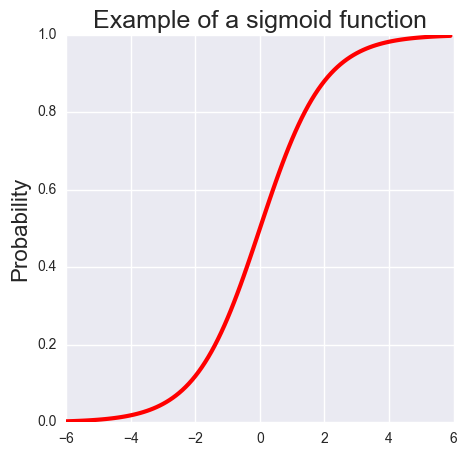

In [3]:
# Plot a sigmoid function
plt.figure(figsize=(5,5))  # open a figure base and determine the size (width, height)

def sigmoid(t):                          # Define the sigmoid function
    return (1/(1 + np.e**(-t)))    

plot_range = np.arange(-6, 6, 0.1)       # range of x values to plot
y_values = sigmoid(plot_range)

# Plot curve
plt.plot(plot_range,   # X-axis range
         y_values,          # Predicted values
         color="red",linewidth=3)
plt.title("Example of a sigmoid function",fontsize=18)
plt.ylabel("Probability",fontsize=16)

Now we will load our sample data and create a 'Alcabuse' variable from 'Dalc' and 'Walc' (weekday and weekend alcohol consumption level, respectively) and make it a binary variable by calling it alcohol abuse if a student scores more than 8 on drinking alcohol in a week. The dataset was retrieved from [here](http://archive.ics.uci.edu/ml/datasets/STUDENT+ALCOHOL+CONSUMPTION#) but slightly modified to better illustrate our purpose.

In [95]:
# Load the data 
df = pd.read_csv('../Data/student-mat.csv')
df['Alcabuse']=0
df.loc[df['Dalc']+df['Walc'] >=8,'Alcabuse']=1 # Let's call it abuse if more than 8 alcohol consumption per week

The hypothesis we want to test is : __"A student is more likely to abuse alcohol if he has more free time."__  
'Alcabuse' will be our response variable Y, measuring the number of drinks per week.   
'freetime' will be our predictor variable X, measuring the degree of free time.

We will use the logit function in the statsmodels package. 

In [96]:
logm = smf.logit('Alcabuse ~ freetime',data=df).fit()
print(logm.summary())

Optimization terminated successfully.
         Current function value: 0.337426
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               Alcabuse   No. Observations:                  395
Model:                          Logit   Df Residuals:                      393
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Feb 2017   Pseudo R-squ.:                  0.2522
Time:                        00:28:11   Log-Likelihood:                -133.28
converged:                       True   LL-Null:                       -178.24
                                        LLR p-value:                 2.489e-21
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -7.6262      0.857     -8.900      0.000        -9.306    -5.947
freetime       1.6416      0.

## Interpreting logistic model coefficients for prediction

We ran our first logit model but we cannot interpret the coefficients like we did in the linear regression model.   Because we applied a logit transform, the coefficients are in log-odds. 
To make them more interpretable we can exponentiate the coefficients and interpret them as either probability or odds-ratios. 

### Interpreting coefficients as probabilities
To change our log-odds coefficients into probabilities we pass the log-odds value of Y into a sigmoid function.
For instance, let's see what the probability is for a student to be an alcohol abuser if he had a level 5 of free time (x=5).  

$x = 5$   
$\beta_0 = -7.6262$  
$\beta_1 = 1.6416$  
## $ Y = \beta_0 + \beta_1\cdot x = -7.6262 + 1.6416 \cdot 5$ 
## $P(Y) = \frac{1}{1 + e^{-(Y)}} = \frac{1}{1 + e^{-(-7.6262 + 1.6416 \cdot 5)}}$

We implement this with the following code by using the 'sigmoid' function as defined earlier in this module.
We also plot the fit of the model.

In [97]:
x = 5
print('x = %i' %x) # x
print('b0 = %f' %logm.params[0]) # b0
print('b1 = %f' %logm.params[1]) # b1
palcabuse = sigmoid(logm.params[0] + logm.params[1] * x)
print('palcabuse = %f' %palcabuse)
print('If a student has %i hours of free time per week, then he has %.2f %% probability of alcohol abuse' % (x,palcabuse*100))
# Note that we had to use double percent sign %% to print % 
# because a single % is reserved for printing inline numbers as in %i or %.2f

x = 5
b0 = -7.626159
b1 = 1.641608
palcabuse = 0.641500
If a student has 5 hours of free time per week, then he has 64.15 % probability of alcohol abuse


### Plotting the predictions of the model

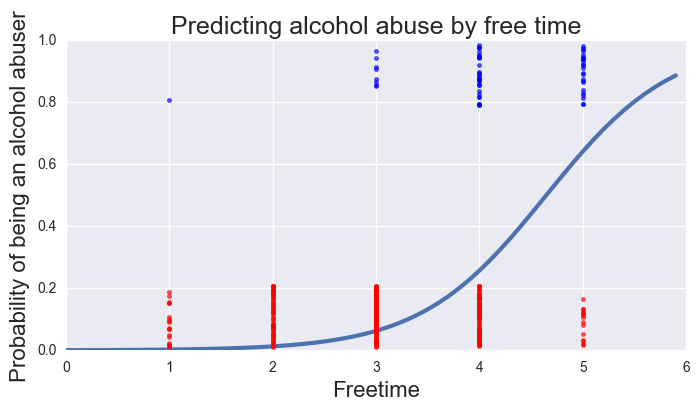

In [98]:
# Plot model fit
xs =  np.arange(min(df.freetime)-1,max(df.freetime)+1,0.1)
ys = np.array([sigmoid(logm.params[0] + logm.params[1] * x) for x in xs])
plt.figure(figsize=(8,4))
plt.plot(xs,ys,linewidth=3)
jitter = np.random.random(len(df.Alcabuse))/5
ys_outcomes = np.abs((df.Alcabuse==1)-0.01-jitter)
alpha = 0.7
plt.plot(df.freetime[df.Alcabuse == 1], ys_outcomes[df.Alcabuse ==1], 'b.', alpha=alpha)
plt.plot(df.freetime[df.Alcabuse == 0], ys_outcomes[df.Alcabuse ==0], 'r.', alpha=alpha)
plt.xlabel("Freetime",fontsize=16)
plt.ylabel("Probability of being an alcohol abuser",fontsize=16)
plt.title("Predicting alcohol abuse by free time",fontsize=18)

### Interpreting coefficients as odds
In some cases it could be more useful to consider the odds of an event happening. 
For example, we might want to be able to make statementes such as "If a person smokes, he is 10 times more likely to get lung cancer compared to a person who doesn't smoke."  The odds of an event happening is defined by

## $odds = \frac{P(\text{event})}{P(\text{no event})} = \frac{P(\text{Y})}{P(\text{not Y})}$
while $P(\text{Y}) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x_1)}}$

and $P(\text{not Y}) = 1 - P(\text{Y})$

If we want to look at how much the odds change for a unit increase in free time, we can use the following 

## $\triangle odds = \frac{\text{odds after a unit change in predictor}}{\text{original odds}} $

So, if we want to calculate the change in odds ratios of being an alcohol abuser when free time increases from 4 to 5, we can calculate the following: 
## $\triangle odds = \frac{\text{odds(Y) when x = 5}}{\text{odds(Y) when x = 4}}  = \frac{\frac{\text{P(Y) when x = 5}}{\text{1 - (P(Y) when x = 5)}}}{\frac{\text{P(Y) when x = 4}}{\text{1 - (P(Y) when x = 4)}}}$


In [ ]:
odd1 = sigmoid(logm.params[0] + logm.params[1] * 5) / (1-sigmoid(logm.params[0] + logm.params[1] * 5))
odd2 = sigmoid(logm.params[0] + logm.params[1] * 4) / (1-sigmoid(logm.params[0] + logm.params[1] * 4))
dodds = odd1/odd2
print('A student with 5hrs of free time compared to a student with 4 is %.2f times more likely to be an alcohol abuser' %dodds)

## Cross-validation 

The best way to compare accuracy of models and see how well your model generalize is to train (or fit) your model on a training dataset then test it on a separate test dataset. If you train and test your model on the same dataset (as we did above) you are likely to get a positvely biased result. The true generalizeability can only be observed when you test your model on a separate hold-out test dataset on which the model was not trained. A simple way to do cross-validation is to split the dataset before you begin your analysis. 

There are many ways to split the dataset but for simplicity we will use the train_test_split function in the module sci-kit learn.  
We will split the data so that the training dataset consists 60% of the data and the test dataset consists 40% of the data.

### 1. Split the data into training and testing datasets

In [99]:
from sklearn.cross_validation import train_test_split
np.random.seed(12345678) # set the random number generator seed to get consistent results
trainratio = .6
train, test = train_test_split(df, train_size=trainratio, random_state=1)
print('train-test ratio %.2f' %(float(len(train))/(len(train)+len(test))))

train-test ratio 0.60


### 2. Fit the model on the training dataset
Now we fit a new model and save it to logmt.  
We will try to predict 'Alcabuse' with 'freetime' and 'goout'  
Note that we specify what dataset we are using by setting data = train. 

In [100]:
# We run the model on the train dataset
logmt = smf.logit('Alcabuse ~ freetime + goout',data=train).fit()
print(logmt.summary())

Optimization terminated successfully.
         Current function value: 0.281857
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               Alcabuse   No. Observations:                  237
Model:                          Logit   Df Residuals:                      234
Method:                           MLE   Df Model:                            2
Date:                Wed, 08 Feb 2017   Pseudo R-squ.:                  0.3493
Time:                        00:28:44   Log-Likelihood:                -66.800
converged:                       True   LL-Null:                       -102.66
                                        LLR p-value:                 2.661e-16
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -10.7962      1.584     -6.817      0.000       -13.900    -7.692
freetime       1.7517      0.

### 3. Calculate predictions on the test dataset
We now use the model with coefficients estimated from the training dataset (logmt) and plug in the predictor variable values from the test dataset by using the .predict method. This method outputs the probabilities for us so we don't have to apply separate sigmoid transform. Therefore the output are the probabilities predicted with our model on the test dataset.

In [101]:
ytestpred = logmt.predict(test)
np.round(ytestpred,2)

array([ 0.02,  0.74,  0.52,  0.08,  0.01,  0.38,  0.33,  0.19,  0.04,
        0.86,  0.  ,  0.33,  0.33,  0.33,  0.33,  0.33,  0.1 ,  0.52,
        0.04,  0.04,  0.02,  0.04,  0.02,  0.52,  0.02,  0.19,  0.86,
        0.02,  0.02,  0.  ,  0.19,  0.33,  0.22,  0.01,  0.01,  0.33,
        0.08,  0.  ,  0.57,  0.19,  0.02,  0.52,  0.02,  0.1 ,  0.04,
        0.01,  0.04,  0.19,  0.02,  0.  ,  0.86,  0.05,  0.  ,  0.04,
        0.1 ,  0.02,  0.04,  0.19,  0.19,  0.08,  0.16,  0.33,  0.05,
        0.01,  0.1 ,  0.08,  0.  ,  0.  ,  0.01,  0.04,  0.02,  0.  ,
        0.  ,  0.1 ,  0.19,  0.16,  0.02,  0.01,  0.33,  0.33,  0.08,
        0.19,  0.02,  0.86,  0.74,  0.02,  0.02,  0.  ,  0.02,  0.19,
        0.04,  0.08,  0.33,  0.04,  0.52,  0.  ,  0.04,  0.33,  0.  ,
        0.04,  0.01,  0.  ,  0.52,  0.02,  0.19,  0.  ,  0.19,  0.19,
        0.19,  0.08,  0.  ,  0.86,  0.19,  0.08,  0.52,  0.01,  0.04,
        0.33,  0.52,  0.19,  0.01,  0.01,  0.04,  0.57,  0.01,  0.86,
        0.08,  0.01,

### 4. Calculate accuracy of the predictions
To calculate the accuracy of the model we need to specify the cutoff for the probabilities to say whether one should be classified as an alcohol abuser or not. For simplicity, let's say that we'll classify the person as an alcohol abuser if the estimated probability is greater than 50%.  

We will then calculate the accuracy of the model in classifying alcohol abuse for the training data and the test data separately

In [102]:
cutoff = .5

# Calculate accuracy for train
ytrainpred = logmt.predict(train)
ytrainpred[ytrainpred>=cutoff] =1 
ytrainpred[ytrainpred<cutoff] =0 
accs_train = pd.crosstab(ytrainpred,train["Alcabuse"])

# Calculate accuracy for test
ytestpred = logmt.predict(test)
ytestpred[ytestpred>=cutoff] =1 
ytestpred[ytestpred<cutoff] =0 
accs_test = pd.crosstab(ytestpred,test["Alcabuse"])

# Overall accuracy
print('Overall Accuracy in Training set : %.2f ' %((accs_train[0][0]+accs_train[1][1])/float(train.shape[0])))
print('overall Accuracy in Testing set  : %.2f ' %((accs_test[0][0]+accs_test[1][1])/float(test.shape[0])))

Overall Accuracy in Training set : 0.88 
overall Accuracy in Testing set  : 0.84 


**Question:** Why do you think the accuracy is lower for the test data compared to the training?

Accuracy is one number to represent the overall model performance, but doesn't differentiate between different types of classification errors such as false positives and false negatives.  Sensitivity and Specificity are useful metrics to assess these aspects of the model's performance.

 | **Predicted Positive** | **Predicted Negative**
--- | --- | ---
**Actual Positive** | 192 | 21
**Actual Negative** | 8 | 16

*Sensitivity* $ \frac{TP}{TP+FN} $ : measures the proportion of positives that are correctly identified (e.g. we correctly identify the alcohol abusers)   
*Specificity* $ \frac{TN}{TN+FP} $ : measures the proportion of negatives that are correctly identified (e.g. we correctly identify the non-alcohol abusers) 

In [ ]:
# Sensitivity and false negatives
print('Training')
display(accs_train)
print('')
print('sensitivity : %.2f ' %(float(accs_train[1][1])/(accs_train[1][1]+accs_train[1][0])))
print('false negative : %.2f ' %(float(accs_train[1][0])/(accs_train[1][1]+accs_train[1][0])))
print('specificity : %.2f ' %(float(accs_train[0][0])/(accs_train[0][0]+accs_train[0][1])))
print('false positives : %.2f ' %(float(accs_train[0][1])/(accs_train[0][0]+accs_train[0][1])))

# Specificity and false positives
print('\n')
print('Test')
display(accs_test)
print('\n')
print('sensitivity : %.2f ' %(float(accs_test[1][1])/(accs_test[1][1]+accs_test[1][0])))
print('false negative : %.2f ' %(float(accs_test[1][0])/(accs_test[1][1]+accs_test[1][0])))
print('specificity : %.2f ' %(float(accs_test[0][0])/(accs_test[0][0]+accs_test[0][1])))
print('false positives : %.2f ' %(float(accs_test[0][1])/(accs_test[0][0]+accs_test[0][1])))

Accuracy, sensitivity, and specificity are all affected if we change the cutoff value to .7
So now, we classify the student as an alcohol abuser if there is more than 80% probability.     
We can see that our overall accuracy increases from 84% to 85%.  
We have a tradeoff of decreasing sensitivity to 28% but increasing specificity to 98%.   
We are less likely to falsely accuse a student(decreased false positive), but we are less able to detect an abusing student (increased false negative).

In [ ]:
ytestpred = logmt.predict(test)
cutoff = .7
ytestpred[ytestpred>=cutoff] =1 
ytestpred[ytestpred<cutoff] =0 
accs = pd.crosstab(ytestpred,test["Alcabuse"])

# Overall accuracy
print ('overall accuracy : %.2f ' %((accs[0][0]+accs[1][1])/float(test.shape[0])))
# Sensitivity and false negatives
print('')
print('sensitivity : %.2f ' %(float(accs[1][1])/(accs[1][1]+accs[1][0])))
print('false negative : %.2f ' %(float(accs[1][0])/(accs[1][1]+accs[1][0])))

# Specificity and false positives
print('')
print('specificity : %.2f ' %(float(accs[0][0])/(accs[0][0]+accs[0][1])))
print('false positives : %.2f ' %(float(accs[0][1])/(accs[0][0]+accs[0][1])))

display(accs)

# Regularization

Regularization is a method to help deal with [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) and also avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting). Overfitting occurs when you have an overly complex model such as having more features(Xs) than observations(Y). For instance, if you try to fit 10 observations with 10 features, each coefficient can be adjusted for a perfect fit but it wouldn't generalize well. In other cases, you might face the problem of feature selection. If you have numerous variables, it is time consuming to try every single combination of features in your model to see what yields the best result. 
<img src="http://i.stack.imgur.com/0NbOY.png">

Regularization attempts to solve this problem by introducting a loss function that penalizes the model for each additional features added to the model. The AIC / BIC values we mentioned in the first session is a form of regularization in comparing models. 

In this section we will focus on feature selection regularization methods Lasso and Ridge regressions.

## Lasso regression
In short, [Lasso](http://stats.stackexchange.com/questions/17251/what-is-the-lasso-in-regression-analysis) is a feature selection method that reduces the number of features to use in a regression.  
This is useful if you have a lot of variables that are correlated or you have more variables than observations.  
[Here](http://studentlife.cs.dartmouth.edu/smartgpa.pdf) is a study from Dartmouth that used Lasso on the Student Life Dataset.

In our example, we will try to find which variables can predict the level of alcohol consumption 'AlcSum'. 

In [103]:
df['AlcSum']=df['Dalc']+df['Walc']

In [104]:
# We have a lot of features to choose from
df.keys()

Index([u'school', u'sex', u'age', u'address', u'famsize', u'Pstatus', u'Medu',
       u'Fedu', u'Mjob', u'Fjob', u'reason', u'guardian', u'traveltime',
       u'studytime', u'failures', u'schoolsup', u'famsup', u'paid',
       u'activities', u'nursery', u'higher', u'internet', u'romantic',
       u'famrel', u'freetime', u'goout', u'Dalc', u'Walc', u'health',
       u'absences', u'G1', u'G2', u'G3', u'Alcabuse', u'AlcSum'],
      dtype='object')

In [105]:
# Make a model with all the feature variables
formula = 'AlcSum ~ school+sex+age+address+famsize+Pstatus+Medu+\
       Fedu+Mjob+Fjob+reason+guardian+traveltime+\
       studytime+failures+schoolsup+famsup+paid+activities+nursery+higher+\
       internet+romantic+famrel+freetime+goout+health+absences+G1+G2+G3'

# Generate a design matrix with the formula
# This automatically generates separate regressors for categorical variables.
from patsy import dmatrices
y, X = dmatrices(formula_like=formula, data=df, return_type='dataframe')
# Ridge if L1_wt = 0 , Lasso if L1_wt = 1
penalty = .036
regm = smf.OLS(y,X).fit_regularized(method='coord_descent', maxiter=1000, alpha=penalty, L1_wt=1.0)
print regm.summary()

                            OLS Regression Results                            
Dep. Variable:                 AlcSum   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     5.282
Date:                Wed, 08 Feb 2017   Prob (F-statistic):           1.15e-18
Time:                        00:29:10   Log-Likelihood:                -829.88
No. Observations:                 395   AIC:                             1742.
Df Residuals:                     354   BIC:                             1905.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                     0 

### How do we determine the penalty value? 
Essentially, we want to select the regularization parameter by identifying the one from a set of possible values (e.g. grid search) that results in the best fit of the model to the data.  However, it is important to note that it is easy to introduce bias into this process by trying a bunch of alphas and selecting the one that works best.  This can lead to optimistic evaluations of how well your model works.

Cross-validation is an ideal method to deal with this.  We can use cross-validation to select the alpha while adding minimal bias to the overall model prediction.

There are several different metrics of model fit to use as a criterion variable.  Log-likelihood or mean squared error are the two most common depending on how you are estimating the parameters (i.e., maximizing log-likelihood or minimizizing squared error).  The Akaike information criterion (AIC) and the Bayes Information criterion (BIC) are two common metrics that apply different penalties to these metrices for the number of free parameters in your model.

Here we will demonstrate using both to select an optimal value of the regularization parameter alpha of the Lasso estimator from an example provided by [scikit-learn](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html). For cross-validation, we use 20-fold with 2 algorithms to compute the Lasso path: coordinate descent, as implemented by the LassoCV class.


C:\Users\charl\Anaconda2i\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\charl\Anaconda2i\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


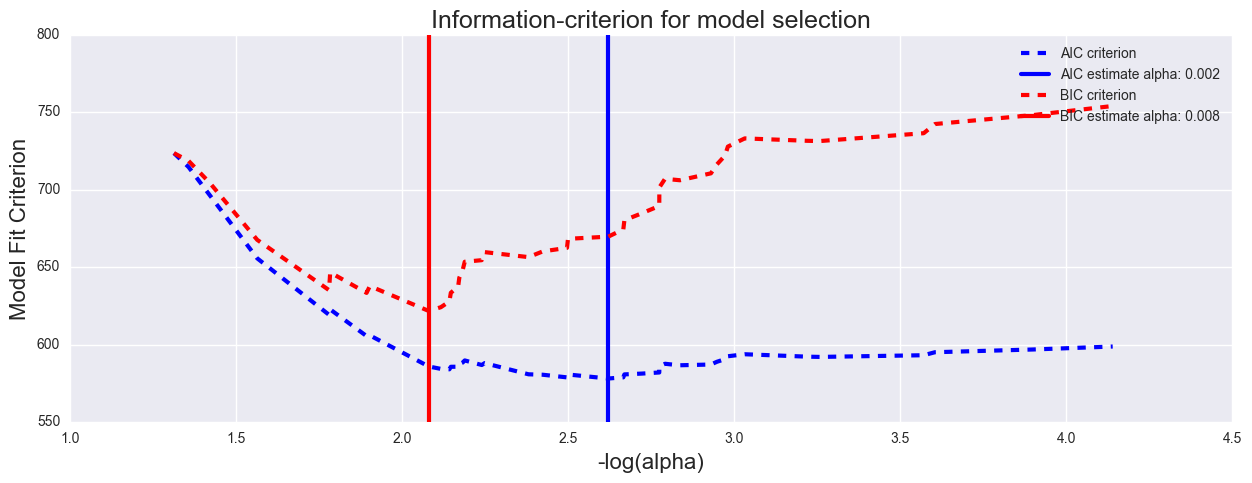

In [106]:
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
import time

# LassoLarsIC: least angle regression with BIC/AIC criterion
model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(X, y)
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X, y)
alpha_aic_ = model_aic.alpha_

def plot_ic_criterion(model, name, value, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='%s estimate alpha: %.3f' %(name,value) )
    plt.xlabel('-log(alpha)',fontsize=16)
    plt.ylabel('Model Fit Criterion',fontsize=16)

plt.figure(figsize=(15,5))
plot_ic_criterion(model_aic, 'AIC', alpha_aic_ , 'b')
plot_ic_criterion(model_bic, 'BIC', alpha_bic_ , 'r')
plt.legend()
plt.title('Information-criterion for model selection',fontsize=18)

Now let's create a plot showing how well each alpha value performs across cross-validation folds

Computing regularization path using the coordinate descent lasso...


C:\Users\charl\Anaconda2i\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(-0.40917512470957829,
 2.5908248752904219,
 2.8969020032543908,
 7.0288515462265631)

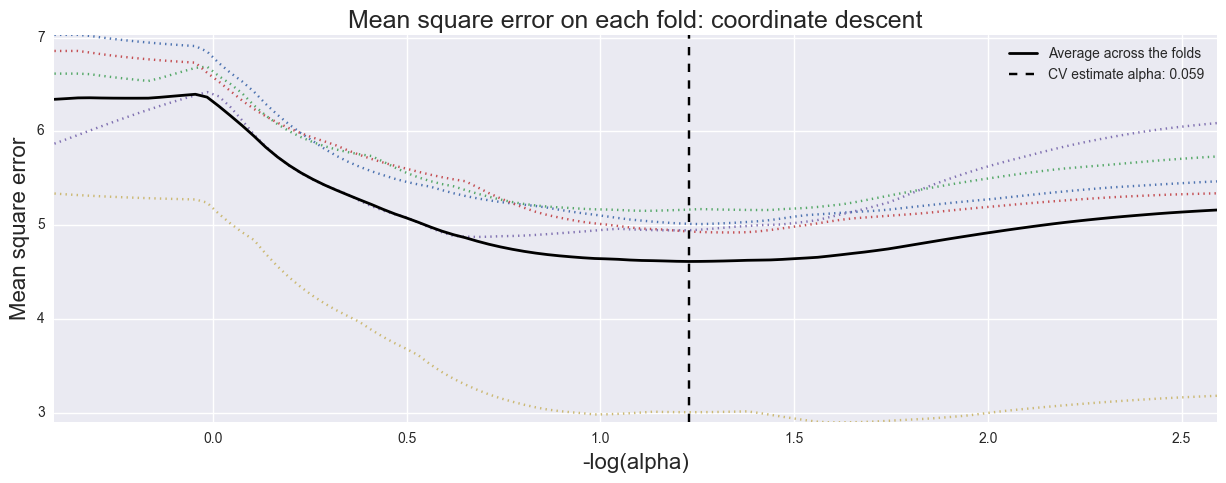

In [111]:
# LassoCV: coordinate descent
y, X = dmatrices(formula_like=formula, data=df, return_type='dataframe')

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(cv=5).fit(X, y)
t_lasso_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.alphas_)

# Display results
plt.figure(figsize=(15,5))
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='CV estimate alpha: %.3f' %model.alpha_ )
plt.legend()
plt.xlabel('-log(alpha)',fontsize=16)
plt.ylabel('Mean square error',fontsize=16)
plt.title('Mean square error on each fold: coordinate descent',fontsize=18)
plt.axis('tight')

## Ridge regression
The goal of the ridge function is to choose a penalty λ for which the coefficients are not rapidly changing and have “sensible” signs. It is especially useful when data suffers from multicollinearity, that is some of your predictor variables are highly correlated. Unlike LASSO, ridge does not produce a sparse solution, but rather shrinks variables that are highly collinear towards zero.

(0.01, 1000000.0, -0.64307293870891302, 1.1466343715406169)

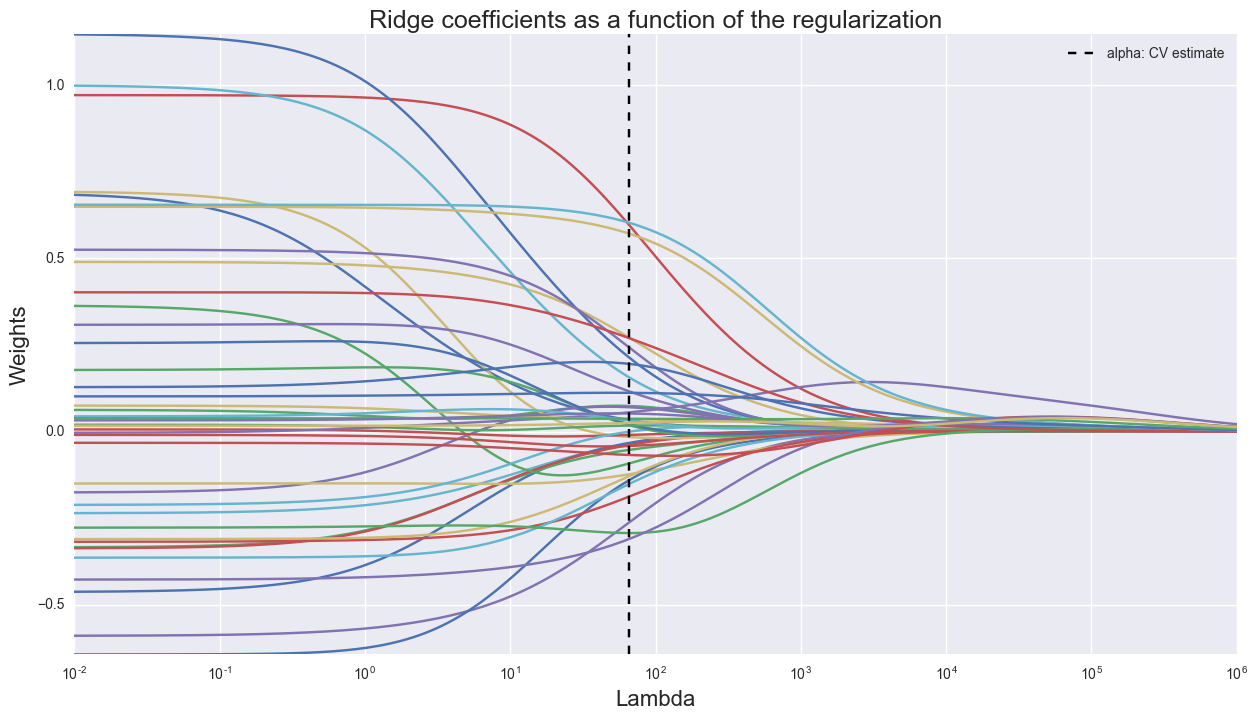

In [108]:
from sklearn import linear_model
y, X = dmatrices(formula_like=formula, data=df, return_type='dataframe')
n_alphas = 200
alphas = np.logspace(-2, 6, n_alphas)

# Get optimal lambda
clf = linear_model.RidgeCV(alphas=alphas)
clf.fit(X,y)
aestim = clf.alpha_ # Estimated regularization param

# Get paths
clf = linear_model.Ridge(fit_intercept=False)
coefs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X, y)
    coefs.append(clf.coef_)

###############################################################################
# Display results
plt.figure(figsize=(15,8))

ax = plt.gca()
ax.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
plt.axvline(aestim, linestyle='--', color='k', label='alpha: CV estimate')
plt.legend()
plt.xlabel('Lambda',fontsize=16)
plt.ylabel('Weights',fontsize=16)
plt.title('Ridge coefficients as a function of the regularization',fontsize=18)
plt.axis('tight')

The points on the left vertical axis (the left ends of the lines) are the ordinary least squares regression values.
These occur for k equal zero. As k is increased, the values of the regression estimates change, often wildly at first.
At some point, the coefficients seem to settle down and then gradually drift towards zero.

The task of the ridge regression analyst is to determine at what value of k these coefficients are at their stable
values. A vertical line is drawn at the value selected for reporting purposes. It is anticipated that you would run
the program several times until an appropriate value of k is determined. In our case, the selected alpha value is indicated by a vertical line at which a = 65.93. The smaller the value of k, the smaller the amount of bias that is included in the estimates.

In [109]:
clf = linear_model.Ridge(fit_intercept=False)
a = aestim
clf.set_params(alpha=a)
clf.fit(X, y)
np.round(clf.coef_,3)

array([[ 0.033,  0.074,  0.596, -0.262,  0.271, -0.035, -0.032, -0.053,
        -0.039,  0.07 , -0.015,  0.157,  0.214, -0.092, -0.009,  0.116,
        -0.123,  0.   , -0.14 ,  0.019, -0.187,  0.243, -0.128, -0.151,
         0.022,  0.017, -0.041,  0.056,  0.036,  0.032,  0.196, -0.293,
         0.27 , -0.31 ,  0.572,  0.603,  0.112,  0.037, -0.067,  0.052,
         0.025]])

In [112]:
# Ridge if L1_wt = 0 , Lasso if L1_wt = 1
penalty = aestim
regm = smf.OLS(y,X).fit_regularized(method='coord_descent', maxiter=1000, alpha=penalty, L1_wt=0)
print regm.summary()

                            OLS Regression Results                            
Dep. Variable:                 AlcSum   R-squared:                      -0.028
Model:                            OLS   Adj. R-squared:                 -0.144
Method:                 Least Squares   F-statistic:                   -0.2422
Date:                Wed, 08 Feb 2017   Prob (F-statistic):               1.00
Time:                        00:33:43   Log-Likelihood:                -927.80
No. Observations:                 395   AIC:                             1938.
Df Residuals:                     354   BIC:                             2101.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                0.0063 

# Individual exercise
Below is the information about the dataset. 

Attribute Information:  
1 school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)   
2 sex - student's sex (binary: 'F' - female or 'M' - male)   
3 age - student's age (numeric: from 15 to 22)   
4 address - student's home address type (binary: 'U' - urban or 'R' - rural)   
5 famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)   
6 Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)   
7 Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 Ã¢â‚¬â€œ 5th to 9th grade, 3 Ã¢â‚¬â€œ secondary education or 4 Ã¢â‚¬â€œ higher education)   
8 Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 Ã¢â‚¬â€œ 5th to 9th grade, 3 Ã¢â‚¬â€œ secondary education or 4 Ã¢â‚¬â€œ higher education)   
9 Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')   
10 Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')   
11 reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')   
12 guardian - student's guardian (nominal: 'mother', 'father' or 'other')   
13 traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)   
14 studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)   
15 failures - number of past class failures (numeric: n if 1<=n<3, else 4)   
16 schoolsup - extra educational support (binary: yes or no)   
17 famsup - family educational support (binary: yes or no)   
18 paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)   
19 activities - extra-curricular activities (binary: yes or no)   
20 nursery - attended nursery school (binary: yes or no)   
21 higher - wants to take higher education (binary: yes or no)   
22 internet - Internet access at home (binary: yes or no)   
23 romantic - with a romantic relationship (binary: yes or no)   
24 famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)   
25 freetime - free time after school (numeric: from 1 - very low to 5 - very high)   
26 goout - going out with friends (numeric: from 1 - very low to 5 - very high)   
27 Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)   
28 Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)   
29 health - current health status (numeric: from 1 - very bad to 5 - very good)   
30 absences - number of school absences (numeric: from 0 to 93)     
31 G1 - first period grade (numeric: from 0 to 20)   
31 G2 - second period grade (numeric: from 0 to 20)   
32 G3 - final grade (numeric: from 0 to 20, output target)   

## Exercise 1
Before you begin, you may want to replace all the 'yes' or 'no' responses in the dataframe to numerical values such as 1 or 0
using the df.replace() method. 

Run a logistic model to see whether studytime predicts 'wanting to take higher education'. 

Based on the model, what is the probability that John wants to pursue higher education if his
studytime value is 2 (he studies 2 hours/week)?

Based on the model what is the probability that Laura wants to pursue higher education if her
studytime value is 3 (she studies 5 hours per week)? 

How much more likely (in odds) is Laura likely to want to pursue higher education than John ?

## Exercise 2
Run a LASSO regression to find what variables predict studytime.   
Use the penalty parameter (alpha) estimated through cross validation of coordinate descent.  
What is your interpretation of the results?  

In [60]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from IPython.display import display, HTML

In [5]:
df = pd.read_csv('../Data/student-mat.csv')
df.replace('yes',1,inplace=True)
df.replace('no',0,inplace=True)

In [7]:
logm = smf.logit('higher ~ studytime',data=df).fit()
print(logm.summary())

Optimization terminated successfully.
         Current function value: 0.181280
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 higher   No. Observations:                  395
Model:                          Logit   Df Residuals:                      393
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Feb 2017   Pseudo R-squ.:                 0.09530
Time:                        07:34:34   Log-Likelihood:                -71.605
converged:                       True   LL-Null:                       -79.148
                                        LLR p-value:                 0.0001028
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.6130      0.630      0.974      0.330        -0.621     1.847
studytime      1.3711      0.

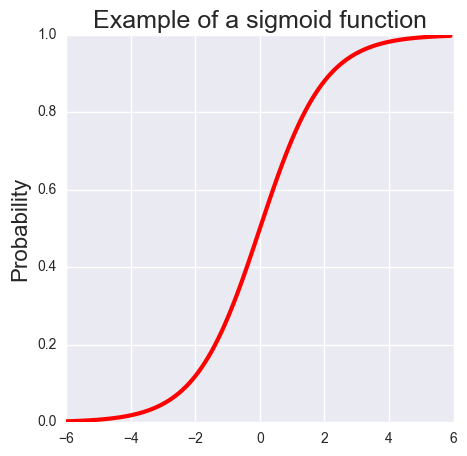

In [54]:
plt.figure(figsize=(5,5))  # open a figure base and determine the size (width, height)

def sigmoid(t):                          # Define the sigmoid function
    return (1/(1 + np.e**(-t)))    

plot_range = np.arange(-6, 6, 0.1)       # range of x values to plot
y_values = sigmoid(plot_range)

# Plot curve
plt.plot(plot_range,   # X-axis range
         y_values,          # Predicted values
         color="red",linewidth=3)
plt.title("Example of a sigmoid function",fontsize=18)
plt.ylabel("Probability",fontsize=16)

In [61]:
x = 2
print('x = %i' %x) # x
print('b0 = %f' %logm.params[0]) # b0
print('b1 = %f' %logm.params[1]) # b1
phigher = sigmoid(logm.params[0] + logm.params[1] * x)
print('phigher = %f' %phigher)
print('If a student has a study time value of %i, then they have %.2f %% probability of wanting to pursue higher education' % (x,phigher*100))

x = 2
b0 = 0.613035
b1 = 1.371139
phigher = 0.966278
If a student has a study time value of 2, then they have 96.63 % probability of wanting to pursue higher education


In [ ]:
#if john has study time value of 2- he has a 96.63% probability of wanting to pursue higher education

In [52]:
x = 3
print('x = %i' %x) # x
print('b0 = %f' %logm.params[0]) # b0
print('b1 = %f' %logm.params[1]) # b1
phigher = sigmoid(logm.params[0] + logm.params[1] * x)
print('phigher = %f' %phigher)
print('If a student has a study time value of %i, then they have %.2f %% probability of wanting to pursue higher education' % (x,phigher*100))

x = 3
b0 = 0.613035
b1 = 1.371139
phigher = 0.991220
If a student has a study time value of 3, then they have 99.12 % probability of wanting to pursue higher education


In [ ]:
#If Laura has a study time value of 3, and studies 5 hours per week, then she has a 99.12% 
#probability of wanting to pursue higher education

In [23]:
np.arange?

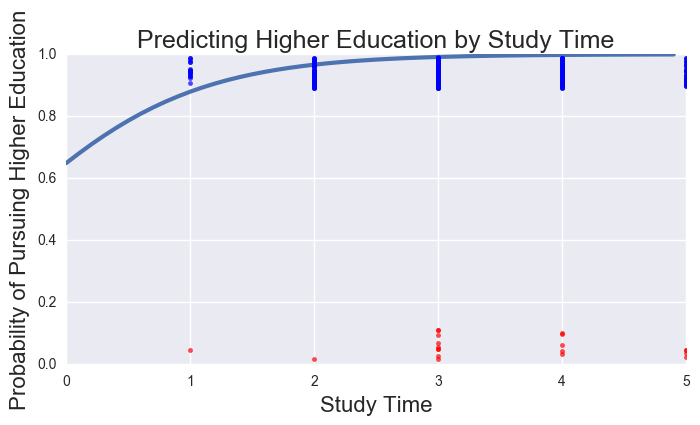

In [29]:
xs =  np.arange(min(df.studytime)-1,max(df.studytime)+1,0.1)
ys = np.array([sigmoid(logm.params[0] + logm.params[1] * x) for x in xs])
plt.figure(figsize=(8,4))
plt.plot(xs,ys,linewidth=3)
jitter = np.random.random(len(df.higher))/10
ys_outcomes = np.abs((df.higher==1)-0.01-jitter)
alpha = 0.7
plt.plot(df.freetime[df.higher == 1], ys_outcomes[df.higher ==1], 'b.', alpha=alpha)
plt.plot(df.freetime[df.higher == 0], ys_outcomes[df.higher ==0], 'r.', alpha=alpha)
plt.xlabel("Study Time",fontsize=16)
plt.ylabel("Probability of Pursuing Higher Education",fontsize=16)
plt.title("Predicting Higher Education by Study Time",fontsize=18)

In [59]:
odd1 = sigmoid(logm.params[0] + logm.params[1] * 3) / (1-sigmoid(logm.params[0] + logm.params[1] * 3))
odd2 = sigmoid(logm.params[0] + logm.params[1] * 2) / (1-sigmoid(logm.params[0] + logm.params[1] * 2))
dodds = odd1/odd2
print [odd1]
print [odd2]
print [dodds]
print('A student with 5hrs of study time compared to a student with 2hrs is %.2f times more likely to want to pursue higher education' %dodds)

[112.8941289378581]
[28.654538962569198]
[3.9398340725470842]
A student with 5hrs of study time compared to a student with 2hrs is 3.94 times more likely to want to pursue higher education


In [64]:
sigmoid(logm.params[0] + logm.params[1] * 3)/ (1-sigmoid(logm.params[0] + logm.params[1] * 3))

112.8941289378581

In [63]:
 (1-sigmoid(logm.params[0] + logm.params[1] * 3))

0.0087800838315872376

In [ ]:
#Exercize Two

In [119]:
df.keys()

Index([u'school', u'sex', u'age', u'address', u'famsize', u'Pstatus', u'Medu',
       u'Fedu', u'Mjob', u'Fjob', u'reason', u'guardian', u'traveltime',
       u'studytime', u'failures', u'schoolsup', u'famsup', u'paid',
       u'activities', u'nursery', u'higher', u'internet', u'romantic',
       u'famrel', u'freetime', u'goout', u'Dalc', u'Walc', u'health',
       u'absences', u'G1', u'G2', u'G3', u'Alcabuse', u'AlcSum'],
      dtype='object')

In [132]:
df['AlcSum']=df['Dalc']+df['Walc']

In [133]:
formula = 'studytime ~ school+sex+age+address+famsize+Pstatus+Medu+\
       Fedu+Mjob+Fjob+reason+guardian+traveltime+\
       failures+schoolsup+famsup+paid+activities+nursery+higher+\
       internet+romantic+famrel+freetime+goout+AlcSum+health+absences+G1+G2+G3'

C:\Users\charl\Anaconda2i\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\charl\Anaconda2i\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


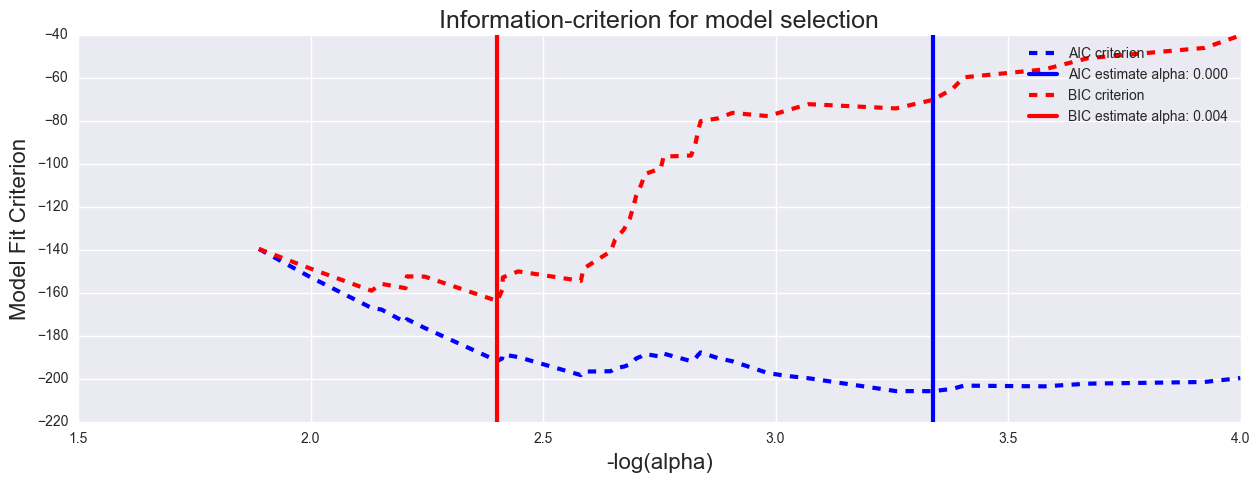

In [134]:
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
import time

# LassoLarsIC: least angle regression with BIC/AIC criterion
model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(X, y)
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X, y)
alpha_aic_ = model_aic.alpha_

def plot_ic_criterion(model, name, value, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='%s estimate alpha: %.3f' %(name,value) )
    plt.xlabel('-log(alpha)',fontsize=16)
    plt.ylabel('Model Fit Criterion',fontsize=16)

plt.figure(figsize=(15,5))
plot_ic_criterion(model_aic, 'AIC', alpha_aic_ , 'b')
plot_ic_criterion(model_bic, 'BIC', alpha_bic_ , 'r')
plt.legend()
plt.title('Information-criterion for model selection',fontsize=18)

Computing regularization path using the coordinate descent lasso...


C:\Users\charl\Anaconda2i\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.26520824415349181,
 3.265208244153492,
 0.39967427256908289,
 0.92985047502025175)

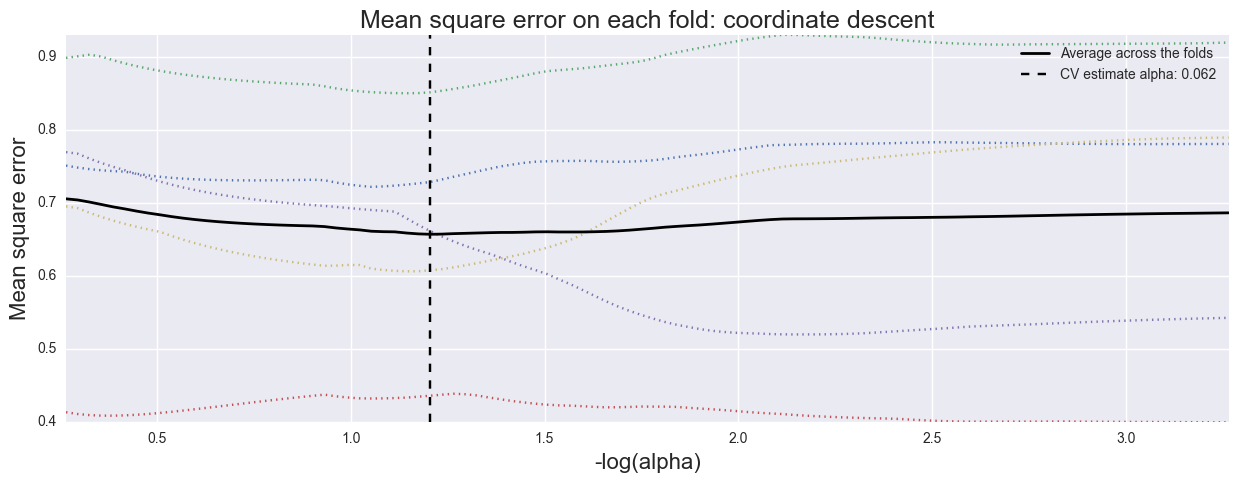

In [135]:
# LassoCV: coordinate descent
y, X = dmatrices(formula_like=formula, data=df, return_type='dataframe')

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(cv=5).fit(X, y)
t_lasso_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.alphas_)

# Display results
plt.figure(figsize=(15,5))
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='CV estimate alpha: %.3f' %model.alpha_ )
plt.legend()
plt.xlabel('-log(alpha)',fontsize=16)
plt.ylabel('Mean square error',fontsize=16)
plt.title('Mean square error on each fold: coordinate descent',fontsize=18)
plt.axis('tight')

In [136]:
from patsy import dmatrices
y, X = dmatrices(formula_like=formula, data=df, return_type='dataframe')
# Ridge if L1_wt = 0 , Lasso if L1_wt = 1
penalty = .062
regm = smf.OLS(y,X).fit_regularized(method='coord_descent', maxiter=1000, alpha=penalty, L1_wt=1.0)
print regm.summary()

                            OLS Regression Results                            
Dep. Variable:              studytime   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.192
Date:                Wed, 08 Feb 2017   Prob (F-statistic):              0.206
Time:                        01:25:38   Log-Likelihood:                -465.80
No. Observations:                 395   AIC:                             1014.
Df Residuals:                     354   BIC:                             1177.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                     0 

In [ ]:
#After plotting the performance of alpha values / coordinate descent of alpha values for five folds of data, the cross
#validation method found 0.062 to be an optimal alpha value for the lasso regression. This was the case because the 
#average of all five folds had the lowest mean squared error at alpha = 0.062.

#Grades from the first and second period of the school term were correlated with study time. Grades were measured on a
#scale from one to twenty; on average, an increase grade by 1 point in the first quarter resulted in a 0.0346 increase
#in the subjects studytime above the mean. However, this result was not significant, given that P>|t| is equal to .16,
#far above the 0.05 threshold

#Furthermore, each additional drink consumed in a week resulted in, on average, a 0.0539 decrease in subjects studytime
#values as relative to the mean studytime. These results were significant at P>|t| = 0.03.

#Third, sex turned out to be a predictor. Being a male resulted in, on average, a 0.1865 decrease in 
#study time relative to the mean. Again, these results were significant at P>|t| = 0.042.

#Finally, the age variable was a fairly strong predictor of study time. Specifically, students one year older than their
#young counter parts, on average, had 0.1 higher studytime values. 